# Ivancich Stefano 1227846
# HOMEWORK 3 - Deep Reinforcement Learning

**Done:**
 - 3 pt: train a deep RL agent on a different Gym environment. You are free to choose whatever Gym environment you like from the available list, or even explore other simulation platforms: https://gym.openai.com/envs
 - ...

**Doing:**
 - 2 pt: extend the notebook used in Lab 07, in order to study how the exploration profile (either using eps-greedy or softmax) impacts the learning curve. Try to **tune the model hyperparameters** or **tweak the reward function** in order to **speed-up learning convergence** (i.e., reach the same accuracy with fewer training episodes).
 - 3 pt: extend the notebook used in Lab 07, in order to learn to control the CartPole environment using directly the screen pixels, rather than the compact state representation used during the Lab (cart position, cart velocity, pole angle, pole angular velocity). This will require to change the “observation_space”.
 
**TODO:**
- ...

 

In [ ]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeory

# 1) CartPole gym environment

## 1.1) Experience replay (Replay Memory)

In [ ]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append( (state, action, next_state, reward) ) # Add the tuple (state, action, next_state, reward) to the queue

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

In [ ]:
######## TEST IF THE MEMORY WORKS ###########à
# Define the replay memory
replay_mem = ReplayMemory(capacity=3)

# Push some samples
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(1,1,1,1)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(2,2,2,2)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(3,3,3,3)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(4,4,4,4)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(5,5,5,5)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")

# Check the content of the memory
print('\nCONTENT OF THE MEMORY')
print(replay_mem.memory)

# Random sample
print('\nRANDOM SAMPLING')
for i in range(5):
    print(replay_mem.sample(2)) # Select 2 samples randomly from the memory

## 1.2) Policy network
The policy network takes a state as input, and provides the Q-value for each of the possible actions.

Let's define a simple generic fully-connected feed forward network with `state_space_dim` inputs and `action_space_dim` outputs (e.g. 2 hidden layers with 64 neurons each). 

Be sure to keep a linear output activation.

In [ ]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
                nn.Linear(state_space_dim, 128),
                nn.Tanh(),
                nn.Linear(128, 128),
                nn.Tanh(),
                nn.Linear(128, action_space_dim)
                )

    def forward(self, x):
        return self.linear(x)

In [ ]:
# Define an example network
state_space_dim=4
net = DQN(state_space_dim=state_space_dim, action_space_dim=2)

## 1.3) Exploration Policy
Starting from the estimated Q-values, we need to choose the proper action. This action may be the one expected to provide the highest long term reward (exploitation), or maybe we want to find a better policy by choosing a different action (exploration).

The exploration policy controls this behavior, typically by varying a single parameter.

Since our Q-values estimates are far from the true values at the beginning of the training, a high exploration is preferred in the initial phase.

The steps are:

`Current state -> Policy network -> Q-values -> Exploration Policy -> Action`

### 1.3.1) Epsilon-greedy policy
Choose a non optimal action with probability epsilon, otherwise choose the best action (the one corresponding to the highest Q-value).

In [ ]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

In [ ]:
# Test if it works as expected
state = (0, 0, 0, 0)
epsilon = 0.5
chosen_action, q_values = choose_action_epsilon_greedy(net, state, epsilon)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

### 1.3.2) Softmax policy
With a softmax policy we choose the action based on a distribution obtained applying a softmax (with temperature  𝜏 ) to the estimated Q-values. The highest the temperature, the more the distribution will converge to a random uniform distribution. At zero temperature, instead, the policy will always choose the action with the highest Q-value.

In [ ]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

In [ ]:
# Test if it works as expected
state = (0, 0, 0, 0)
temperature = 1
chosen_action, q_values = choose_action_softmax(net, state, temperature)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

### 1.3.3) Exploration profile
Let's consider, for example, an exponentially decreasing exploration profile using a softmax policy.

$$
\text{softmax_temperature}  = \text{initial_temperature} * \text{exp_decay}^i \qquad \text{for $i$ = 1, 2, ..., num_iterations } 
$$

Alternatively, you can consider an epsilon greedy policy. In this case the exploration would be controlled by the epsilon parameter, for which you should consider a different initial value (max 1). 

In [ ]:
### Define exploration profile
initial_value = 5
#num_iterations = 1000
num_iterations = 1000

exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

## 1.4) Gym Environment (CartPole-v1)
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

In [ ]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

### 1.4.1) Test Environment with a Random Agent

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
#env = wrap_env(env, video_callable=lambda episode_id: True)

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done and score < 490:
      # Choose a random action
      action = random.choice([0, 1])
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment (optional, comment this line to speed up the simulation)
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 

env.close()


## 1.5) Network update

### 1.5.1) Initialization

In [ ]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### PARAMETERS
"""gamma = 0.97   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-2   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training
"""

gamma = 0.98   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-2   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

In [ ]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

### 1.5.2) Update function

In [ ]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

## 1.6) Training loop

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

        # Choose the action following the policy
        action, q_values = choose_action_softmax(policy_net, state, temperature=tau)

        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)

        # We apply a (linear) penalty when the cart is far from center
        pos_weight = 1
        reward = reward - pos_weight * np.abs(state[0]) 

        # Update the final score (+1 for each step)
        score += 1

        # Apply penalty for bad state
        if done: # if the pole has fallen down 
            reward += bad_state_penalty
            next_state = None

        # Update the replay memory
        replay_mem.push(state, action, next_state, reward)

        # Update the network
        if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
            update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

        # Visually render the environment (disable to speed up the training)
        #env.render()

        # Set the current state for the next iteration
        state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

env.close()

## 1.7) Final test

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(1) # Set a random seed for the environment (reproducible results)

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
        # Choose the best action (temperature 0)
        action, q_values = choose_action_softmax(policy_net, state, temperature=0)
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)
        # Visually render the environment
        #env.render()
        # Update the final score (+1 for each step)
        score += reward 
        # Set the current state for the next iteration
        state = next_state
        # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

# 2) Control CartPole using screen pixels

In [1]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeory

In [2]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append( (state, action, next_state, reward) ) # Add the tuple (state, action, next_state, reward) to the queue

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

In [3]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
                nn.Linear(state_space_dim, 128),
                nn.Tanh(),
                nn.Linear(128, 128),
                nn.Tanh(),
                nn.Linear(128, action_space_dim)
                )

    def forward(self, x):
        return self.linear(x)

In [4]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

In [5]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

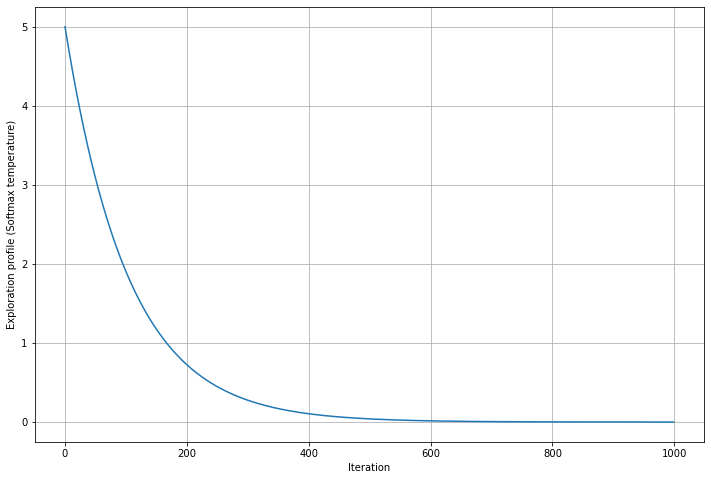

In [6]:
### Define exploration profile
initial_value = 5
#num_iterations = 1000
num_iterations = 1000

exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

In [7]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### PARAMETERS
"""gamma = 0.97   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-2   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training
"""

gamma = 0.98   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-2   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

In [20]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

#state_space_dim=43*100
state_space_dim=172*400

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 68800
ACTION SPACE SIZE: 2


In [21]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

In [22]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    #states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    states      = torch.stack([s[0] for s in batch])
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    #non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended
    non_final_next_states = torch.stack([s[2] for s in batch if s[2] is not None])
    
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

## 2.?) Image Cutting and rescaling

In [23]:
def preproces(statePixel):
    statePixel=statePixel[150:322,100:500,2]
    #statePixel = statePixel.reshape((1,43, 4, 100, 4)).max(4).max(2)  #Reshape 4 time smaller
    #statePixel = statePixel.reshape((1,43, 1, 100, 1)).max(4).max(2)  
    statePixel = torch.tensor(statePixel.copy(), dtype=torch.float32)
    #statePixel=torch.flatten(statePixel)
    return statePixel

torch.Size([172, 400])


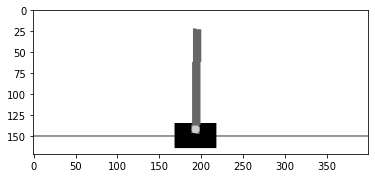

In [24]:
#Test image rescaling

env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

state = env.reset()
statePixel= env.render(mode='rgb_array')

statePixel=preproces(statePixel)

env.close()

print(img.shape)

img=statePixel
plt.imshow(img.cpu().squeeze().numpy(),cmap='gray')
plt.show()

## 2.?) Training

In [25]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    statePixel= env.render(mode='rgb_array')
    statePixel=preproces(statePixel)
    statePixel=torch.flatten(statePixel)
    
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

        # Choose the action following the policy
        action, q_values = choose_action_softmax(policy_net, statePixel, temperature=tau)

        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)

        # We apply a (linear) penalty when the cart is far from center
        pos_weight = 1
        reward = reward - pos_weight * np.abs(state[0]) 
        

        # Update the final score (+1 for each step)
        score += 1

        # Apply penalty for bad state
        if done: # if the pole has fallen down 
            reward += bad_state_penalty
            next_state = None
            next_state_Pixel=None
            
        if type(next_state)!="NoneType":
            next_state_Pixel= env.render(mode='rgb_array')
            next_state_Pixel = preproces(next_state_Pixel)
            
            #img=next_state_Pixel
            #plt.imshow(img.cpu().squeeze().numpy(),cmap='gray')
            #plt.show()
            
            next_state_Pixel=torch.flatten(next_state_Pixel)
            

        # Update the replay memory
        replay_mem.push(statePixel, action, next_state_Pixel, reward)

        # Update the network
        if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
            update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

        # Visually render the environment (disable to speed up the training)
        #env.render()

        # Set the current state for the next iteration
        state = next_state
        statePixel=next_state_Pixel

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
        
        """aaa= env.render(mode='rgb_array')
        aaa = preproces(aaa)
        img=aaa
        plt.imshow(img.cpu().squeeze().numpy(),cmap='gray')
        plt.show()"""

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

env.close()

C:\Users\stefano\.conda\envs\gputest\lib\site-packages\ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Updating target network...
EPISODE: 1 - FINAL SCORE: 12 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 4.810549903022062
EPISODE: 6 - FINAL SCORE: 14 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: 34 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: 27 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 4.583799618258814
Updating target network...
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: 31 - Temperature: 4.4961209333351855
EPISODE: 13 - FINAL SCORE: 32 - Temperature: 4.452912527905132
EPISODE: 14 - FINAL SCORE: 20 - Temperature: 4.4101193618175
EPISODE: 15 - FINAL SCORE: 12 - Temperature: 4.367737444559107
EPISODE: 16 - FINAL SCO

EPISODE: 125 - FINAL SCORE: 43 - Temperature: 1.5098587532885988
EPISODE: 126 - FINAL SCORE: 43 - Temperature: 1.495348781221229
EPISODE: 127 - FINAL SCORE: 29 - Temperature: 1.4809782521904595
EPISODE: 128 - FINAL SCORE: 14 - Temperature: 1.466745826127518
EPISODE: 129 - FINAL SCORE: 22 - Temperature: 1.4526501758418962
EPISODE: 130 - FINAL SCORE: 11 - Temperature: 1.4386899868975886
Updating target network...
EPISODE: 131 - FINAL SCORE: 19 - Temperature: 1.4248639574905198
EPISODE: 132 - FINAL SCORE: 27 - Temperature: 1.4111707983271493
EPISODE: 133 - FINAL SCORE: 54 - Temperature: 1.397609232504243
EPISODE: 134 - FINAL SCORE: 30 - Temperature: 1.3841779953898012
EPISODE: 135 - FINAL SCORE: 12 - Temperature: 1.3708758345051302
EPISODE: 136 - FINAL SCORE: 12 - Temperature: 1.3577015094080467
EPISODE: 137 - FINAL SCORE: 15 - Temperature: 1.344653791577205
EPISODE: 138 - FINAL SCORE: 22 - Temperature: 1.3317314642975362
EPISODE: 139 - FINAL SCORE: 12 - Temperature: 1.3189333225467887
EP

EPISODE: 247 - FINAL SCORE: 15 - Temperature: 0.46482585620722544
EPISODE: 248 - FINAL SCORE: 54 - Temperature: 0.46035880909101823
EPISODE: 249 - FINAL SCORE: 17 - Temperature: 0.4559346909764403
EPISODE: 250 - FINAL SCORE: 30 - Temperature: 0.4515530893092621
Updating target network...
EPISODE: 251 - FINAL SCORE: 13 - Temperature: 0.4472135954999631
EPISODE: 252 - FINAL SCORE: 18 - Temperature: 0.44291580488563
EPISODE: 253 - FINAL SCORE: 22 - Temperature: 0.43865931669222175
EPISODE: 254 - FINAL SCORE: 10 - Temperature: 0.4344437339971967
EPISODE: 255 - FINAL SCORE: 27 - Temperature: 0.430268663692499
EPISODE: 256 - FINAL SCORE: 72 - Temperature: 0.4261337164479012
EPISODE: 257 - FINAL SCORE: 22 - Temperature: 0.42203850667469833
EPISODE: 258 - FINAL SCORE: 44 - Temperature: 0.4179826524897514
EPISODE: 259 - FINAL SCORE: 18 - Temperature: 0.4139657756798767
EPISODE: 260 - FINAL SCORE: 11 - Temperature: 0.4099875016665764
Updating target network...
EPISODE: 261 - FINAL SCORE: 22 - Te

EPISODE: 368 - FINAL SCORE: 22 - Temperature: 0.14449008773881147
EPISODE: 369 - FINAL SCORE: 15 - Temperature: 0.14310151603795834
EPISODE: 370 - FINAL SCORE: 21 - Temperature: 0.1417262887221671
Updating target network...
EPISODE: 371 - FINAL SCORE: 56 - Temperature: 0.14036427754986935
EPISODE: 372 - FINAL SCORE: 31 - Temperature: 0.13901535551191777
EPISODE: 373 - FINAL SCORE: 29 - Temperature: 0.13767939681974212
EPISODE: 374 - FINAL SCORE: 22 - Temperature: 0.13635627689361954
EPISODE: 375 - FINAL SCORE: 33 - Temperature: 0.1350458723510572
EPISODE: 376 - FINAL SCORE: 25 - Temperature: 0.13374806099528672
EPISODE: 377 - FINAL SCORE: 11 - Temperature: 0.1324627218038693
EPISODE: 378 - FINAL SCORE: 14 - Temperature: 0.13118973491741018
EPISODE: 379 - FINAL SCORE: 16 - Temperature: 0.1299289816283816
EPISODE: 380 - FINAL SCORE: 16 - Temperature: 0.12868034437005305
Updating target network...
EPISODE: 381 - FINAL SCORE: 18 - Temperature: 0.12744370670552838
EPISODE: 382 - FINAL SCORE

EPISODE: 488 - FINAL SCORE: 24 - Temperature: 0.045350246465342955
EPISODE: 489 - FINAL SCORE: 13 - Temperature: 0.04491442370508329
EPISODE: 490 - FINAL SCORE: 40 - Temperature: 0.044482789267780265
Updating target network...
EPISODE: 491 - FINAL SCORE: 38 - Temperature: 0.04405530290301379
EPISODE: 492 - FINAL SCORE: 31 - Temperature: 0.04363192474717643
EPISODE: 493 - FINAL SCORE: 25 - Temperature: 0.04321261531975604
EPISODE: 494 - FINAL SCORE: 24 - Temperature: 0.04279733551965424
EPISODE: 495 - FINAL SCORE: 10 - Temperature: 0.04238604662154012
EPISODE: 496 - FINAL SCORE: 14 - Temperature: 0.041978710272239095
EPISODE: 497 - FINAL SCORE: 14 - Temperature: 0.041575288487156414
EPISODE: 498 - FINAL SCORE: 16 - Temperature: 0.04117574364673507
EPISODE: 499 - FINAL SCORE: 15 - Temperature: 0.04078003849294769
EPISODE: 500 - FINAL SCORE: 14 - Temperature: 0.040388136125822205
Updating target network...
EPISODE: 501 - FINAL SCORE: 41 - Temperature: 0.040000000000000924
EPISODE: 502 - F

EPISODE: 607 - FINAL SCORE: 15 - Temperature: 0.014371929182929243
EPISODE: 608 - FINAL SCORE: 34 - Temperature: 0.01423381275942651
EPISODE: 609 - FINAL SCORE: 31 - Temperature: 0.014097023655742735
EPISODE: 610 - FINAL SCORE: 48 - Temperature: 0.013961549116132753
Updating target network...
EPISODE: 611 - FINAL SCORE: 13 - Temperature: 0.013827376507436042
EPISODE: 612 - FINAL SCORE: 22 - Temperature: 0.013694493317898678
EPISODE: 613 - FINAL SCORE: 12 - Temperature: 0.013562887156006585
EPISODE: 614 - FINAL SCORE: 15 - Temperature: 0.013432545749330034
EPISODE: 615 - FINAL SCORE: 27 - Temperature: 0.013303456943379198
EPISODE: 616 - FINAL SCORE: 20 - Temperature: 0.013175608700470751
EPISODE: 617 - FINAL SCORE: 18 - Temperature: 0.013048989098605331
EPISODE: 618 - FINAL SCORE: 18 - Temperature: 0.012923586330355803
EPISODE: 619 - FINAL SCORE: 20 - Temperature: 0.012799388701766197
EPISODE: 620 - FINAL SCORE: 19 - Temperature: 0.012676384631261242
Updating target network...
EPISODE: 

EPISODE: 725 - FINAL SCORE: 13 - Temperature: 0.0045987977001641055
EPISODE: 726 - FINAL SCORE: 20 - Temperature: 0.0045546025554013755
EPISODE: 727 - FINAL SCORE: 12 - Temperature: 0.004510832132696006
EPISODE: 728 - FINAL SCORE: 13 - Temperature: 0.004467482350404482
EPISODE: 729 - FINAL SCORE: 21 - Temperature: 0.0044245491661085035
EPISODE: 730 - FINAL SCORE: 36 - Temperature: 0.004382028576238024
Updating target network...
EPISODE: 731 - FINAL SCORE: 11 - Temperature: 0.004339916615697915
EPISODE: 732 - FINAL SCORE: 19 - Temperature: 0.0042982093574982115
EPISODE: 733 - FINAL SCORE: 12 - Temperature: 0.004256902912387922
EPISODE: 734 - FINAL SCORE: 30 - Temperature: 0.004215993428492347
EPISODE: 735 - FINAL SCORE: 23 - Temperature: 0.004175477090953888
EPISODE: 736 - FINAL SCORE: 22 - Temperature: 0.004135350121576308
EPISODE: 737 - FINAL SCORE: 21 - Temperature: 0.00409560877847241
EPISODE: 738 - FINAL SCORE: 23 - Temperature: 0.004056249355715102
EPISODE: 739 - FINAL SCORE: 51 -

EPISODE: 842 - FINAL SCORE: 10 - Temperature: 0.0014858239773477791
EPISODE: 843 - FINAL SCORE: 12 - Temperature: 0.0014715449831296866
EPISODE: 844 - FINAL SCORE: 11 - Temperature: 0.001457403212215962
EPISODE: 845 - FINAL SCORE: 15 - Temperature: 0.0014433973458697963
EPISODE: 846 - FINAL SCORE: 13 - Temperature: 0.001429526078027643
EPISODE: 847 - FINAL SCORE: 17 - Temperature: 0.0014157881151774234
EPISODE: 848 - FINAL SCORE: 12 - Temperature: 0.0014021821762379074
EPISODE: 849 - FINAL SCORE: 29 - Temperature: 0.0013887069924392503
EPISODE: 850 - FINAL SCORE: 23 - Temperature: 0.0013753613072046771
Updating target network...
EPISODE: 851 - FINAL SCORE: 18 - Temperature: 0.0013621438760333085
EPISODE: 852 - FINAL SCORE: 10 - Temperature: 0.001349053466384106
EPISODE: 853 - FINAL SCORE: 10 - Temperature: 0.001336088857560939
EPISODE: 854 - FINAL SCORE: 14 - Temperature: 0.0013232488405987512
EPISODE: 855 - FINAL SCORE: 12 - Temperature: 0.0013105322181508256
EPISODE: 856 - FINAL SCOR

EPISODE: 959 - FINAL SCORE: 9 - Temperature: 0.0004800543610741552
EPISODE: 960 - FINAL SCORE: 18 - Temperature: 0.0004754409657119511
Updating target network...
EPISODE: 961 - FINAL SCORE: 18 - Temperature: 0.00047087190578026024
EPISODE: 962 - FINAL SCORE: 11 - Temperature: 0.000466346755208858
EPISODE: 963 - FINAL SCORE: 21 - Temperature: 0.0004618650920221191
EPISODE: 964 - FINAL SCORE: 11 - Temperature: 0.0004574264982996684
EPISODE: 965 - FINAL SCORE: 24 - Temperature: 0.0004530305601374089
EPISODE: 966 - FINAL SCORE: 12 - Temperature: 0.000448676867608925
EPISODE: 967 - FINAL SCORE: 11 - Temperature: 0.00044436501472725615
EPISODE: 968 - FINAL SCORE: 26 - Temperature: 0.00044009459940703825
EPISODE: 969 - FINAL SCORE: 9 - Temperature: 0.00043586522342700857
EPISODE: 970 - FINAL SCORE: 18 - Temperature: 0.00043167649239287135
Updating target network...
EPISODE: 971 - FINAL SCORE: 18 - Temperature: 0.00042752801570051987
EPISODE: 972 - FINAL SCORE: 9 - Temperature: 0.0004234194064

# 3) MountainCar-v0 gym environment


## 3.1) Initialize

In [ ]:
### Create environment
env = gym.make('MountainCar-v0') # Initialize the Gym environment

env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

In [ ]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

In [ ]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### PARAMETERS
gamma = 0.97   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-2   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

## 3.2) Train

In [ ]:
# Initialize the Gym environment
env = gym.make('MountainCar-v0') 
env.seed(0) # Set a random seed for the environment (reproducible results)

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

        # Choose the action following the policy
        action, q_values = choose_action_softmax(policy_net, state, temperature=tau)

        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)

        # We apply a (linear) penalty 
        pos_weight = 6
        
        if (action ==0 and state[1]<0) or (action==2 and state[1]>0):
            reward= reward + pos_weight * np.abs(state[0]+0.5)
        else:reward= reward-2

        # Score= position
        score=state[0]

        # Update the replay memory
        replay_mem.push(state, action, next_state, reward)

        # Update the network
        if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
            update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

        # Visually render the environment (disable to speed up the training)
        #env.render()

        # Set the current state for the next iteration
        state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau} - REW: {reward}") # Print the final score

env.close()

## 3.3) Test

In [ ]:
# Initialize the Gym environment
env = gym.make('MountainCar-v0') 
env.seed(1) # Set a random seed for the environment (reproducible results)

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
        # Choose the best action (temperature 0)
        action, q_values = choose_action_softmax(policy_net, state, temperature=0)
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)
        # Visually render the environment
        env.render()
        # Update the final score (+1 for each step)
        score = next_state[0]
        # Set the current state for the next iteration
        state = next_state
        # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()